In [1]:
# Another script using a rating system
# This is calculated based on formula from https://www.pro-football-reference.com/.
# Details can be found > https://www.pro-football-reference.com/blog/index4837.html?p=37

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.linear_model import Ridge,LogisticRegression,Lasso
from sklearn.metrics import log_loss
import seaborn as sns
pd.options.display.max_rows = 200

%matplotlib inline

# Data

In [3]:
files = glob.glob('../google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/*')
file_dict = {f.split("/")[-1].split(".")[0]:f for i,f in enumerate(files)}

# Season Stats

In [4]:
teams = pd.read_csv(file_dict['MTeams'],usecols=['TeamID','TeamName'])
SeasonResults = pd.read_csv(file_dict['MRegularSeasonCompactResults'])

In [5]:
SeasonResultsWin = SeasonResults[['Season','DayNum','WTeamID','WScore','LTeamID','LScore','WLoc']].copy()
SeasonResultsWin.columns = ['Season','DayNum','TeamID','Score','TeamID_OPP','Score_OPP','WLoc']
SeasonResultsWin['result'] = 1
SeasonResultsLose = SeasonResults[['Season','DayNum','WTeamID','WScore','LTeamID','LScore','WLoc']].copy()
SeasonResultsLose.columns = ['Season','DayNum','TeamID_OPP','Score_OPP','TeamID','Score','WLoc']
SeasonResultsLose['result'] = 0
SeasonResultsTeams = pd.concat([SeasonResultsWin,SeasonResultsLose],axis=0,sort=True)

SeasonResultsTeams['WL'] = np.where(SeasonResultsTeams['Score']-SeasonResultsTeams['Score_OPP']>0,'W','L')

# Tourney Stats

In [6]:
TourneyCompactResults = pd.read_csv(file_dict['MNCAATourneyCompactResults'])
TourneyCompactResults['TeamID1'] = np.minimum(TourneyCompactResults['WTeamID'],TourneyCompactResults['LTeamID'])
TourneyCompactResults['TeamID2'] = np.maximum(TourneyCompactResults['WTeamID'],TourneyCompactResults['LTeamID'])
TourneyCompactResults['result'] = np.where(TourneyCompactResults['WTeamID']==TourneyCompactResults['TeamID1'],1,0)
TourneyCompactResults['ID'] = TourneyCompactResults['Season'].astype(str)+ '_' +TourneyCompactResults['TeamID1'].astype(str)+ '_' +TourneyCompactResults['TeamID2'].astype(str)


In [7]:
def SOS(data,seasons,alpha=0.0008,reg_type='Lasso',zscore=True,days = 133):
    """Find the true team strength by adjusting for opponent and average margin of victory. 
    Computes the strength based on a single season.
    The regression is based on an m*m matrix where m is the number of teams.
    Input:
    data - pandas data frame with same structure as SeasonResultsTeams
    files
    seasons - a list/array of seasons to compute the strength for
    alpha (default = 0.008) - the regularization parameter
    reg_type (default = Lasso) - 'Lasso', 'Ridge' or 'Logistic'
    days (default = 133) - only includes games with DayNum < days. 
    zscore (default = False) - if True computes the zscore for each season
    Example:
    team_strength = SOS(SeasonResults,np.arange(1985,2020),alpha=0.001,reg_type='Lasso')
    """
    
    if reg_type == 'Lasso':
        lin = Lasso(alpha=alpha);
    elif reg_type == 'Ridge':
        lin = Ridge(alpha=alpha);
    else:
        print('reg_type is not recognized. Using Lasso.')
        lin = Lasso(alpha=alpha);
        
    srs = []
    for season in seasons:
        single_season = data.loc[(data['Season']==season)&(data['DayNum']<=days)].copy()
        team_results =  single_season.groupby(['TeamID','TeamID_OPP']).size().unstack(1).fillna(0)
        team_results = -(team_results.T/team_results.sum(axis=1).T).T

        outcomes = single_season.groupby('TeamID')[['Score','Score_OPP']].mean()
        outcomes['scoreDiff'] = outcomes['Score'] - outcomes['Score_OPP']
        y = outcomes['scoreDiff'].values

        A = team_results.values
        np.fill_diagonal(A, 1)
        lin.fit(A,y)
        srs_per_team = lin.coef_
        single_season_srs = pd.DataFrame(srs_per_team,index=team_results.index,columns=['SRS']).reset_index()
        single_season_srs['MOV'] = y
        single_season_srs['Season'] = season
        single_season_srs['SOS'] = single_season_srs['SRS'] - single_season_srs['MOV']
        if zscore:
            single_season_srs['SRS'] = (single_season_srs['SRS'] - single_season_srs['SRS'].mean())/single_season_srs['SRS'].std()
        srs.append(single_season_srs)
    return pd.concat(srs,ignore_index=True)

# Hypertune Regularization Parameter
Using cross validation we are going to see what is the best regularization parameter for the SRS to be predictive in the NCAA tournament

In [8]:
def hypertune_model(reg_type,alphas,zscores):
    # Define predictive model for the trounament with low regularization parameter 
    lr = LogisticRegression(solver='lbfgs',C=1000000,random_state=0,max_iter=1500)

    all_scores = []
    for zscore in zscores:
        for alpha in alphas:  
            
#      get team strength
            team_strength = SOS(SeasonResultsTeams,
                                 np.arange(1985,2020),
                                 alpha=alpha,
                                 reg_type=reg_type,
                                 zscore=zscore)

#      join to tournament data

            TourneyResults = (TourneyCompactResults
                                     .merge(team_strength,left_on=['Season','TeamID1'],right_on=['Season','TeamID'],how='left')
                                     .drop('TeamID',axis=1)
                                     .merge(team_strength,left_on=['Season','TeamID2'],right_on=['Season','TeamID'],how='left')
                                     .drop('TeamID',axis=1)
                                    ).copy()

            TourneyResults['strength_diff'] = TourneyResults['SRS_x'] - TourneyResults['SRS_y']

            cols = ['strength_diff']

            # define model variables
            X = TourneyResults.loc[:,cols]
            y = TourneyResults[['result']].values.ravel()
            
            ## Could use unique here instead of ravel;
                ## .concat , .unique

            # run cross validation
            scores = np.zeros((5,1))
            for ii,s in enumerate(range(2014,2019)):
                idxTrain = (TourneyResults['Season'] < s) 
                idxTest = (TourneyResults['Season'] == s)
                
#             fit all models

                lr.fit(X.loc[idxTrain],y[idxTrain])

                ypred_lr = lr.predict_proba(X.loc[idxTest])

                scores[ii,0] = log_loss(y[idxTest],ypred_lr[:,1])

            all_scores.append([zscore,alpha,np.mean(scores),np.std(scores)])

    return pd.DataFrame(all_scores,columns=['zscore','alpha','log_loss_mean','log_loss_std'])   

# Ridge Regression
Results with method 1 was 0.546306

In [9]:
all_scores_df = hypertune_model('Ridge',[0.001,0.01,0.1,1,10,100],[False,True])

In [10]:
# use this to highlight the minimum value - https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

In [11]:
all_scores_df
all_scores_df.style.apply(highlight_min,subset=['log_loss_mean'])

,zscore,alpha,log_loss_mean,log_loss_std
0,False,0.001000,0.548127,0.041472
1,False,0.010000,0.546461,0.041055
2,False,0.100000,0.556322,0.036384
3,False,1.000000,0.643838,0.023937
4,False,10.000000,0.670334,0.017392
5,False,100.000000,0.673286,0.016413
6,True,0.001000,0.548489,0.042086
7,True,0.010000,0.546654,0.041419
8,True,0.100000,0.555952,0.036745
9,True,1.000000,0.644054,0.025012


# Lasso Regression

In [12]:
all_scores_df2 = hypertune_model('Lasso',[0.0005,0.001,0.002,0.004,0.008,0.016],[False,True])

In [13]:
all_scores_df2
all_scores_df2.style.apply(highlight_min,subset=['log_loss_mean'])

,zscore,alpha,log_loss_mean,log_loss_std
0,False,0.000500,0.545271,0.040823
1,False,0.001000,0.544806,0.040348
2,False,0.002000,0.550650,0.040108
3,False,0.004000,0.578154,0.038092
4,False,0.008000,0.623629,0.042657
5,False,0.016000,0.661755,0.030470
6,True,0.000500,0.545401,0.041393
7,True,0.001000,0.544721,0.040928
8,True,0.002000,0.550253,0.041154
9,True,0.004000,0.577596,0.040023


Our previous best result was 0.546306.
We can see that we got the best results for predicting the NCAA tournament using this method!!!

Another thing to notice is that the zscore did seem to help in this case.

# Find the strongest team since 1985*

*If we didn't care about the NCAA tournament we wouldn't use regularization. Since we are trying to find the strength of the teams as a predictive feature for the NCAA tournament we are using the regularization we found with the hypertunning.

In [14]:
teams_sos = SOS(SeasonResultsTeams,np.arange(1985,2020),alpha=0.001,zscore=True)
conf = pd.read_csv(file_dict['MTeamConferences'])
teams_sos = (teams_sos
             .merge(teams[['TeamID','TeamName']],on='TeamID',how='left')
             .merge(conf,on=['TeamID','Season'])
             .sort_values(by='SRS',ascending=False)
             .reset_index(drop=True)
            )
teams_sos[['TeamName','Season','SRS','MOV','SOS','ConfAbbrev']].head(10)

### SRS = SRS(before zscore) - MOV, Margin of Victory(MOV), Strength of Schedule(SOS) ###

,TeamName,Season,SRS,MOV,SOS,ConfAbbrev
0,Duke,1999,3.684896,25.424242,8.632206,acc
1,Duke,2001,3.328810,20.848485,9.751051,acc
2,UNLV,1991,3.214135,28.933333,2.372293,big_west
3,Duke,1998,3.209445,21.166667,8.539421,acc
4,Kentucky,1996,3.186182,22.200000,6.955198,sec
5,Gonzaga,2019,3.155749,23.787879,4.230072,wcc
6,Oklahoma,1988,3.143722,23.393939,4.872336,big_eight
7,Kentucky,2015,3.134946,20.941176,6.374745,sec
8,North Carolina,1986,3.097695,18.838710,8.157938,acc
9,Kentucky,1997,3.046292,21.363636,6.629357,sec


We can also see each teams Margin Of Victory (MOV) and Strength Of Schedule (SOS). In fact, the SOS is calculated by SRS (before zscore) - MOV.

# Average SOS for Each Conference

Box plot my mean data

In [15]:
strength_by_conf = (teams_sos[teams_sos['Season']==2019]
                      .groupby('ConfAbbrev')[['SOS']]
                      .mean()
                      .sort_values(by='SOS',ascending=False)
                      .reset_index()
                     )

Seaborn library to make the box plot

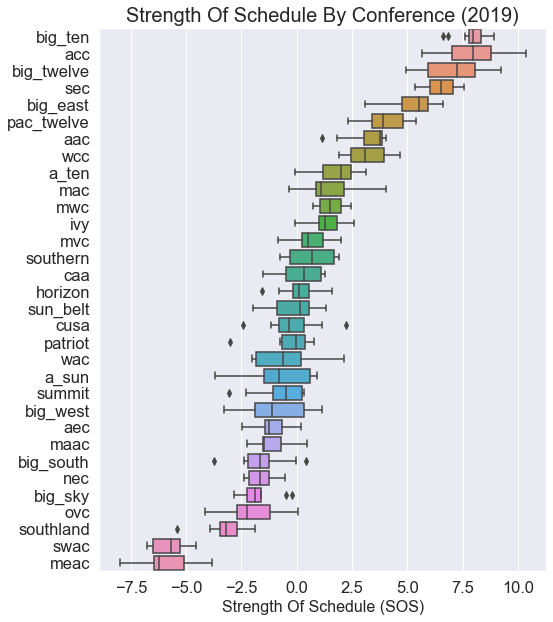

In [16]:
sns.set(font_scale=1.5)
fig,ax = plt.subplots(figsize=(8,10))

ax = sns.boxplot(y="ConfAbbrev",
                 x="SOS",
                 data=teams_sos[teams_sos['Season']==2019],
                 orient='h',
                 order=strength_by_conf['ConfAbbrev'].tolist())

ax.set_xlabel('Strength Of Schedule (SOS)',fontsize=16);
ax.set_ylabel('',fontsize=16);
ax.set_title('Strength Of Schedule By Conference (2019)',fontsize=20);

In [17]:
#fig.savefig('Simple Rating System.png',bbox_inches='tight')